In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)
from tqdm import tqdm

# Helper Functions to Display Images

In [ ]:
import matplotlib.pyplot as plt

def sample_batch(dataset):
  batch= dataset.take(1).get_single_element()
  if isinstance(batch, tuple):
    batch = batch[0]
  return batch.numpy()

def display_images(images, number_images_to_display=10, size=(20,3), cmap="gray_r", as_type="float32"):
  if images.max()>1.0:
    images=images/255.0
  elif images.min() <0.0:
    images = (images+1.0)/2.0

  plt.figure(figsize=size)

  for i in range(number_images_to_display):
    x1 = plt.subplot(1, number_images_to_display, i+1)
    plt.imshow(images[i].astype(as_type), cmap=cmap)
    plt.axis("off")

  plt.show()

# Data Preparation

We will first download the training data, which is the "Images of Bricks" dataset available on Kaggle.
It contains 40,000 computer-rendered images of 50 toy brick types captured from various angles. (show images from book)

Now go to https://github.com/DiveshRKubal/GenerativeAI/blob/main/download_dataset_from_kaggle/kaggle_data_download.ipynb to show how to download data from Kaggle and store in Google Drive

In [ ]:
#Lets Load Sample 1000 Images
import os
source_dir = "/content/drive/MyDrive/YT/Generative AI/5 - Generative Adversarial Networks/downloaded_data/dataset/"
destination_dir = '/content/drive/MyDrive/YT/Generative AI/5 - Generative Adversarial Networks/downloaded_data/dataset_sample'

#If directory exists, then delete it
del_cmd = "rm -rf "+'"'+destination_dir+'"'
os.system(del_cmd)

mkdir_cmd = "mkdir -p " +'"'+destination_dir+'"'
os.system(mkdir_cmd)

all_files = os.listdir(source_dir)
n_images = 1000
for index, img_name in tqdm(enumerate(all_files)):
  cp_cmd = "cp " + '"'+os.path.join(source_dir, img_name)+'"' + " " + '"'+os.path.join(destination_dir, img_name)+'"'
  os.system(cp_cmd)
  if index>n_images:
    break

501it [03:53,  2.15it/s]


In [ ]:
#We use the Keras function image_dataset_from_directory to create a TensorFlow Dataset
#

train_data = utils.image_dataset_from_directory(
    destination_dir,
    labels=None,
    color_mode="grayscale",
    image_size=(64, 64),
    batch_size=128,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

#This lets us load image batches on-the-fly, as needed (e.g., during training),
#enabling us to handle large datasets without the need to store the entire dataset in memory.
#Additionally, it resizes the images to 64x64, smoothing pixel values in between.

Found 502 files belonging to 1 classes.


# Data Preprocessing

The initial data has pixel intensities within the [0, 255] range. When training GANs, we adjust the scale to [-1, 1]. This adjustment allows us to use the tanh activation function in the generator's final layer, which tends to offer more robust and stronger gradients compared to the sigmoid function.

In [ ]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img



In [ ]:
# print(type(train_data))
# print(train_data.shape)

In [ ]:
train = train_data.map(lambda x: preprocess(x))


In [ ]:
train_sample = sample_batch(train)

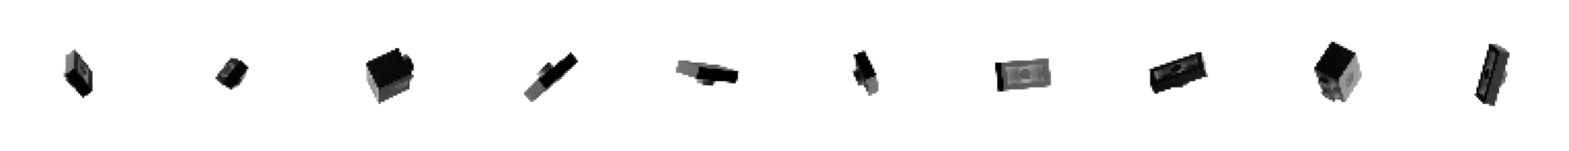

In [ ]:
display_images(train_sample)

# Lets Design THE *DISCRIMINATOR*

The discriminator's task is to determine whether an image is real or fake, essentially making it a supervised image classification problem. We can use a similar architecture to what we discussed in the Autoencoders session, with just one output node.

In [ ]:
#Define the Input to the discriminator (the image).
discriminator_input = layers.Input(shape=(64, 64, 1))

#Stack Conv2D layers on top of each other, with BatchNormalization
#


x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)


x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)


x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)


x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

#Flatten the last convolutional layer - by this point, the shape of the
#tensor is 1x1x1, so there is no need for a final Dense layer.

x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)

#The Keras model that defines the discriminator—a model that takes an
#input image and outputs a single number between 0 and 1.
discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (Batch  (None, 16, 16, 128)       512       
 Normalization)                                                  
                                                             

You all might have observed that we used a stride of 2 in some Conv2D layers to reduce the tensor's size as it goes through the network (from 64 to 32, 16, 8, 4, and eventually 1), while increasing the channel count (from 1 to 64, 128, 256, and finally 512) before producing a single prediction.

The final Conv2D layer uses a sigmoid activation, which yields a value between 0 and 1.

# Lets Design THE *GENERATOR*

Now, let's create the generator. It takes a vector sampled from a multivariate standard normal distribution as input and produces an image of the same size as those in the original training data.

The generator's role might sound similar to the decoder in a variational autoencoder (VAE). In fact, the GAN's generator serves the same purpose as the VAE's decoder, which is to transform a latent space vector into an image. This idea of mapping from a latent space back to the original domain is widely used in generative modeling. It allows us to manipulate latent space vectors to alter high-level features of images in the original domain.

In [ ]:
#Define the Input to the generator—a vector of length 100.
generator_input = layers.Input(shape=(100,))

#We use aReshapelayers to give a 1 × 1 × 100 tensor, so that we can
#start applying convolutional transpose operations.
x = layers.Reshape((1, 1, 100))(generator_input)

#We pass this through four Conv2DTranspose layers, with BatchNormalization and
#LeakyReLU layers sandwiched in between.
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

#The final Conv2DTranspose layer use a tanh activation function to transform the
#output to the range [–1, 1], to match the original image domain.
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    1,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)

#The Keras model that defines the generator—a model that accepts a
#vector of length 100 and outputs a tensor of shape [64, 64, 1].
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_3 (Bat  (None, 4, 4, 512)         2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 256)         2097

We can observe that we apply a stride of 2 in certain Conv2DTranspose layers to increase the tensor's size through the network (from 1 to 4, 8, 16, 32, and finally 64), while reducing the number of channels (starting with 512, then 256, 128, 64, and ultimately 1, to match the grayscale output).

# Lets Train DCGAN

:Keras provides us with the ability to create a custom train_step function, to implement this logic

In [ ]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy() #The loss function for both the generator and discriminator is BinaryCrossentropy
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]

        #To train the network, first sample a batch of vectors from a multivariate standard normal distribution.
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            #Next, pass these batch of vectors through the generator to produce a batch of generated images.
            generated_images = self.generator(
                random_latent_vectors, training=True
            )

            #Now ask the discriminator to predict the realness of the batch of realimages...
            real_predictions = self.discriminator(real_images, training=True)

            #...and also the batch of generated images.
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            #ADDING NOISE TO THE LABELS
            #One helpful technique in GAN training involves adding slight random
            #noise to training labels.
            #This label smoothing acts as way to tame the discriminator, so that
            #it is presented with a more challenging task and doesn’t overpower the generator.
            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + 0.1 * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - 0.1 * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            #The discriminator loss is the average binary cross-entropy across both
            #the real images (with label 1) and fake images (with label 0).
            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            #The generator loss is the binary cross-entropy between the discriminator
            #predictions for the generated images and a label of 1.
            g_loss = self.loss_fn(real_labels, fake_predictions)

        #Lets update the weights of the discriminator and generator separately.
        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

The discriminator and generator are constantly fighting for dominance, which can cause instability in DCGAN training. Ideally, the training process will find an equilibrium that allows the generator to learn meaningful information from the discriminator and the quality of the images will start to improve. After sufficient epochs, the discriminator often becomes more dominant, yet this might not matter since, by that time, the generator could have already learned to create good-quality images

In [ ]:
# Create a DCGAN
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=100
)

# Actual Training

In [ ]:
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999
    ),
)

In [ ]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        # display_images(
        #     generated_images,
        #     save_to="./output/generated_img_%03d.png" % (epoch),
        # )

In [ ]:
dcgan.fit(
    train,
    epochs=500,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=100),
    ],
)

Epoch 1/500
4/4 [==============================] - 21s 565ms/step - d_loss: 0.3736 - d_real_acc: 0.8267 - d_fake_acc: 0.6793 - d_acc: 0.7530 - g_loss: 1.4756 - g_acc: 0.3207
Epoch 2/500
4/4 [==============================] - 2s 238ms/step - d_loss: -0.1510 - d_real_acc: 0.9960 - d_fake_acc: 0.9960 - d_acc: 0.9960 - g_loss: 3.1631 - g_acc: 0.0040
Epoch 3/500
4/4 [==============================] - 2s 309ms/step - d_loss: -0.2951 - d_real_acc: 1.0000 - d_fake_acc: 0.9980 - d_acc: 0.9990 - g_loss: 4.1424 - g_acc: 0.0020
Epoch 4/500
4/4 [==============================] - 3s 246ms/step - d_loss: -0.3657 - d_real_acc: 1.0000 - d_fake_acc: 0.9900 - d_acc: 0.9950 - g_loss: 4.7740 - g_acc: 0.0100
Epoch 5/500
4/4 [==============================] - 3s 312ms/step - d_loss: -0.4508 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 6.4492 - g_acc: 0.0000e+00
Epoch 6/500
4/4 [==============================] - 2s 212ms/step - d_loss: -0.4436 - d_real_acc: 1.0000 - d_fake_acc: 0.9920 -

In [ ]:
# Save the final models
generator.save("./models/generator")
.save("./models/discriminator")

# Lets Generate new images

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 100))

In [ ]:
# Decode the sampled points
reconstructions = generator.predict(z_sample)

1/1 [==============================] - 0s 500ms/step


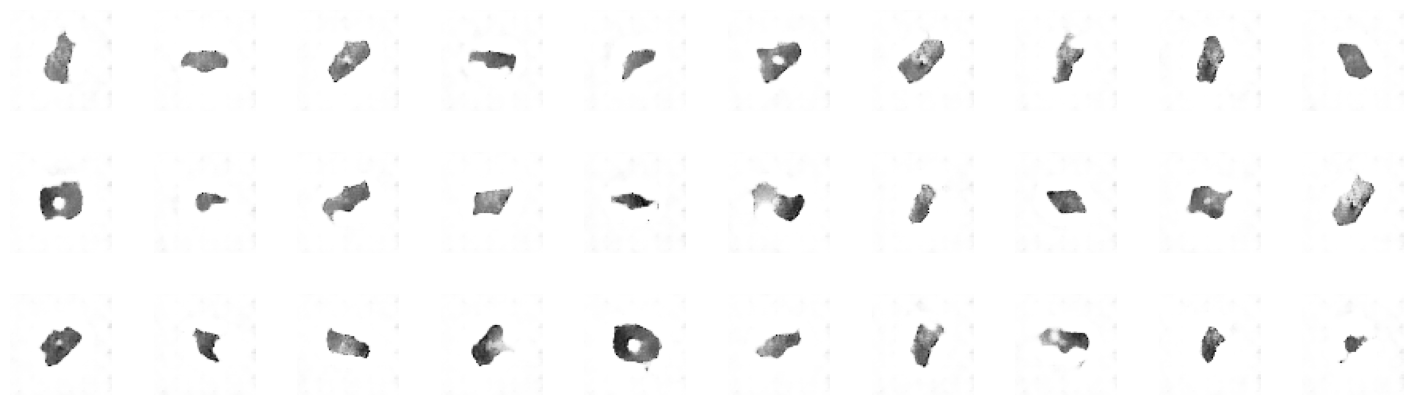

In [ ]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")